source: https://medium.com/towards-formula-1-analysis/how-i-analyze-formula-1-data-with-python-2021-italian-gp-dfb11db4b73


**Lap comparison between drivers**

*Here we analyze the battle between VER and SAI in the first laps of the 2023 Monza GP*

# 1º: Setting the work environment up

In [ ]:
!pip install fastf1

In [ ]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

In [ ]:
# Setup plotting
plotting.setup_mpl()

# Ignore pandas warnings
pd.options.mode.chained_assignment = None

# 2º: Select the data

In [ ]:
# Race to analyze (Year, 'Location', 'Session (FP1, FP2, FP3, Q, R)')
race = ff1.get_session(2023, 'Monza', 'R')

In [ ]:
# Get the selected race info
race.load()

In [ ]:
race

2023 Season Round 14: Italian Grand Prix - Race

In [ ]:
# Get laps info
laps = race.laps

In [ ]:
# Choose the drivers to be studied
driver1 = 'SAI'
driver2 = 'VER'

In [ ]:
# Get the laps info of the drivers
laps_driver1 = laps.pick_driver(driver1)
laps_driver2 = laps.pick_driver(driver2)

In [ ]:
# If we only want to analyze stint 1 (until first pitstop) - pitstop distorts plots
laps_driver1 = laps_driver1.loc[laps_driver1['Stint'] == 1]
laps_driver2 = laps_driver2.loc[laps_driver2['Stint'] == 1]

In [ ]:
# Create a DataFrame of all the distances between Ricciardo and Verstappen at any moment during any lap (comparing lap by lap)
full_distance_driver1_driver2 = pd.DataFrame()

# DF of the average distance per lap
average_distance_driver1_driver2 = pd.DataFrame()

In [ ]:
# Iterate the rows (laps) of a DataFrame in a loop, providing access to each row one by one
for lap in laps_driver2.iterlaps():     # El que va detrás
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()     # 1-load telemetry /2-add column of m driven /3-add col of driver_ahead y distance_...

    # This loop only runs when driver ahead is driver1 (SAI, '55'), otherwise we compare wrong distance gaps (just this fight)
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "55"]

    if len(telemetry) != 0:    # Check that the box is not empty. If it is, SAI is no longer in front of it and is no longer of interest.
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]    # Select the columns we want to know (the two added before)
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1                            # Include the lap number (new column), to compare

        full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)   # Add lap_telemetry rows to the dataframe

        # Average / median distance (ignore NaN values, ex: pitstops)
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        # New row to the dataframe: distances between pilots at a specific moment in time
        average_distance_driver1_driver2 = average_distance_driver1_driver2.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        }, ignore_index = True)


# 3º: Plot the analyzed data
don't be nervous, it's always the same, it's very intuitive

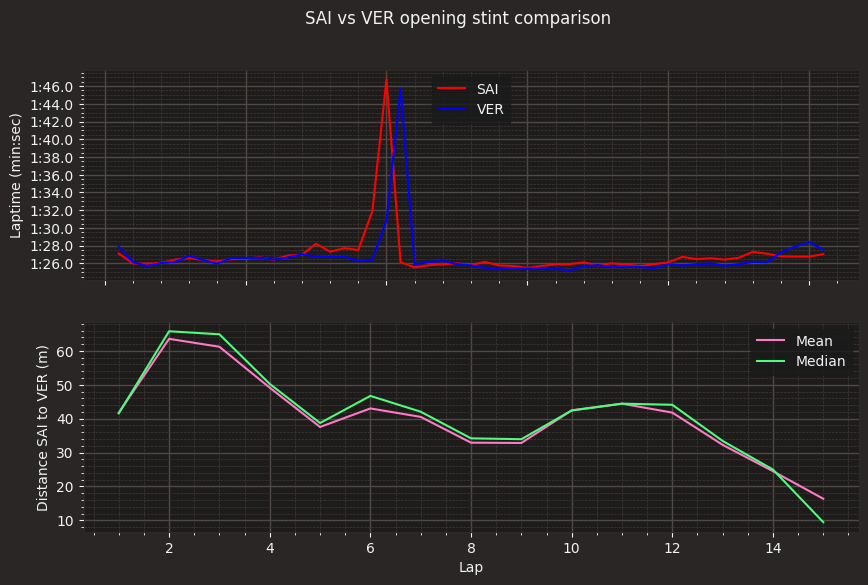

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots(2)      # Indicates that there will be 2 subplots
fig.suptitle(f"{driver1} vs {driver2} opening stint comparison")

# 1º: consists of the lap times (minutes) during the opening stint
ax[0].plot(laps_driver1['LapNumber'], laps_driver1['LapTime'], label=driver1, color='red')
ax[0].plot(laps_driver2['LapNumber'], laps_driver2['LapTime'], label=driver2, color='blue')
ax[0].set(ylabel='Laptime (min:sec)', xlabel='Lap')
ax[0].legend(loc="upper center")

# 2º: average distance (meters) between Verstappen and Sainz.
ax[1].plot(average_distance_driver1_driver2['Lap'], average_distance_driver1_driver2['Mean'], label='Mean')
ax[1].plot(average_distance_driver1_driver2['Lap'], average_distance_driver1_driver2['Median'], label='Median')
ax[1].set(ylabel=f"Distance {driver1} to {driver2} (m)", xlabel='Lap')
ax[1].legend(loc="upper right")

# Hide axis labels on subplots that are not on the outer edges (no 2 times 'lap')
for a in ax.flat:
    a.label_outer()

plt.show()

# 4º: Discovering telemetry

In [ ]:
# Get lap data (telemetry plots lap 15, when VER takes the lead)
lap_telemetry_driver1 = laps_driver1.loc[laps_driver1['LapNumber']==15].get_car_data().add_distance()
lap_telemetry_driver2 = laps_driver2.loc[laps_driver2['LapNumber']==15].get_car_data().add_distance()

# Just to see distance between drivers in the first plot
distance_lap12 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==12]
distance_lap13 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==13]
distance_lap14 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==14]
distance_lap15 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==15]

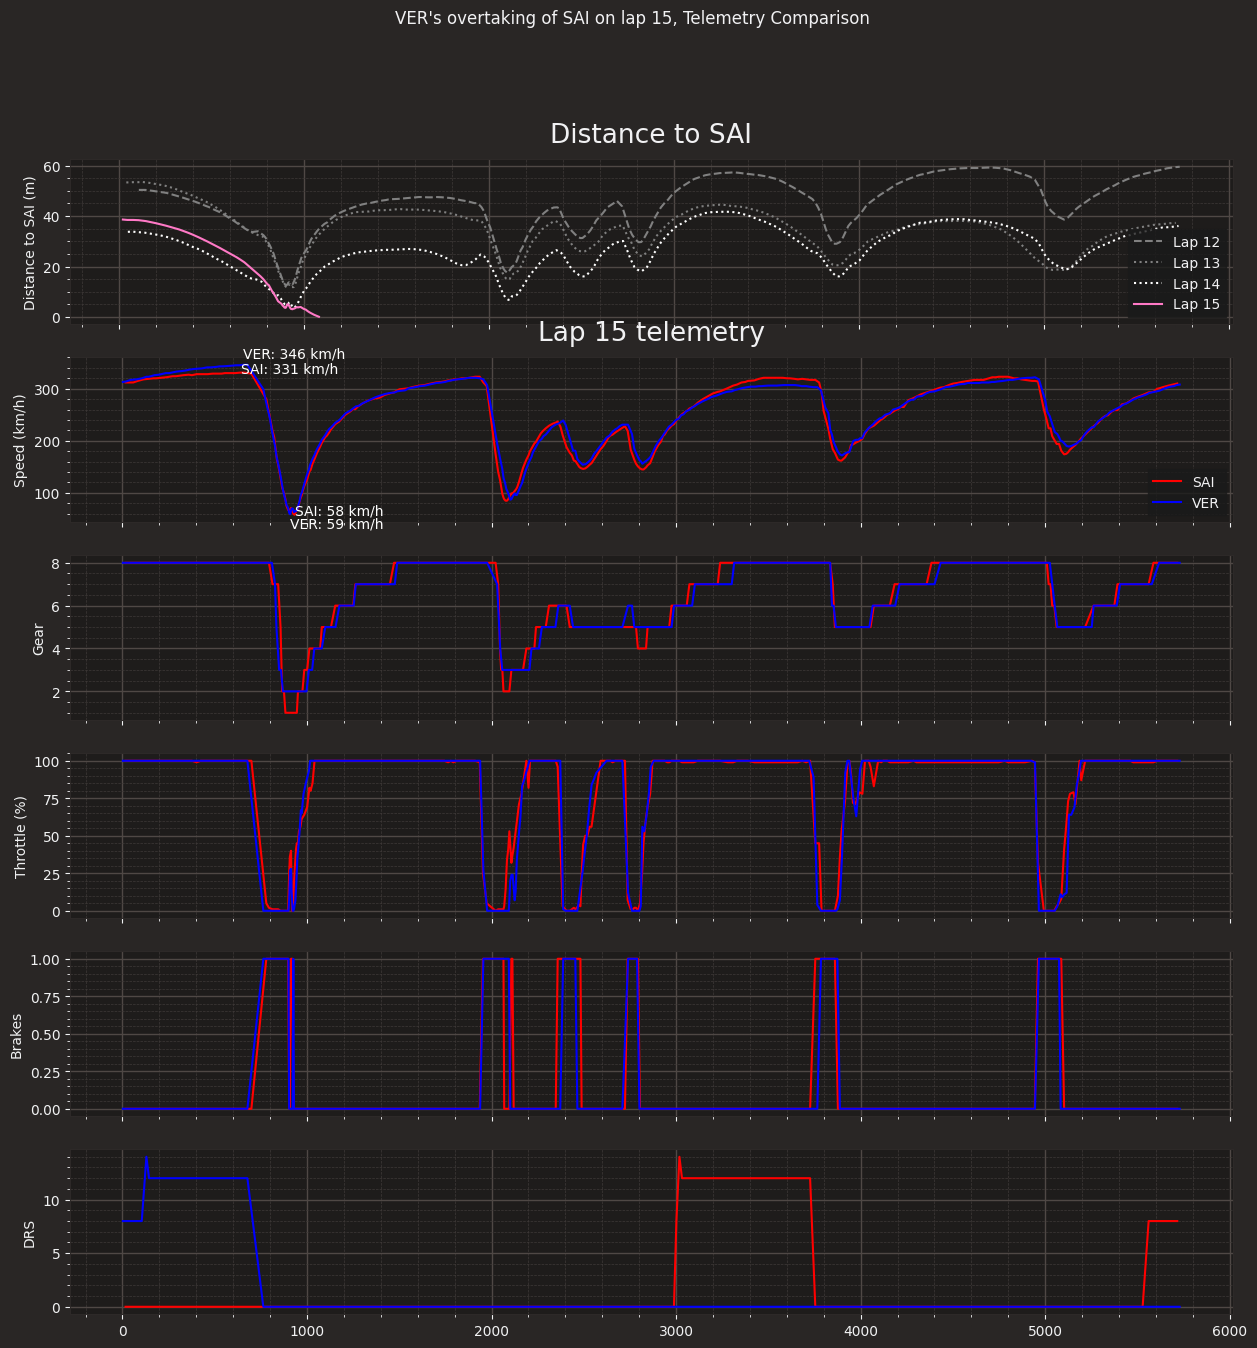

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]

fig, ax = plt.subplots(6)
fig.suptitle("VER's overtaking of SAI on lap 15, Telemetry Comparison")

ax[0].title.set_text(f"Distance to {driver1}")
ax[0].plot(distance_lap12['Distance'], distance_lap12['DistanceToDriverAhead'], label='Lap 12', linestyle='dashed', color='grey')
ax[0].plot(distance_lap13['Distance'], distance_lap13['DistanceToDriverAhead'], label='Lap 13', linestyle='dotted', color='grey')
ax[0].plot(distance_lap14['Distance'], distance_lap14['DistanceToDriverAhead'], label='Lap 14', linestyle='dotted', color='white')
ax[0].plot(distance_lap15['Distance'], distance_lap15['DistanceToDriverAhead'], label='Lap 15')   #overtake
ax[0].legend(loc="lower right")
ax[0].set(ylabel=f'Distance to {driver1} (m)')

ax[1].title.set_text("Lap 15 telemetry")
ax[1].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Speed'], label=driver1, color='red')
ax[1].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Speed'], label=driver2, color='blue')
ax[1].set(ylabel='Speed (km/h)')
ax[1].legend(loc="lower right")

# Maximum and Minimum speed of drivers
driver1_max_speed = lap_telemetry_driver1['Speed'].max()
driver1_min_speed = lap_telemetry_driver1['Speed'].min()
driver2_max_speed = lap_telemetry_driver2['Speed'].max()
driver2_min_speed = lap_telemetry_driver2['Speed'].min()
ax[1].annotate(f'{driver1}: {driver1_max_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmax()], driver1_max_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')   #valores x,y | posición texto
ax[1].annotate(f'{driver1}: {driver1_min_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmin()], driver1_min_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')
ax[1].annotate(f'{driver2}: {driver2_max_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmax()], driver2_max_speed), textcoords="offset points", xytext=(0, 5), ha='left', color='white')
ax[1].annotate(f'{driver2}: {driver2_min_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmin()], driver2_min_speed), textcoords="offset points", xytext=(0, -10), ha='left', color='white')

ax[2].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['nGear'], label=driver1, color='red')
ax[2].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['nGear'], label=driver2, color='blue')
ax[2].set(ylabel='Gear')

ax[3].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Throttle'], label=driver1, color='red')
ax[3].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Throttle'], label=driver2, color='blue')
ax[3].set(ylabel='Throttle (%)')

ax[4].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Brake'], label=driver1, color='red')
ax[4].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Brake'], label=driver2, color='blue')
ax[4].set(ylabel='Brakes')

ax[5].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['DRS'], label=driver1, color='red')
ax[5].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['DRS'], label=driver2, color='blue')
ax[5].set(ylabel='DRS')

# Hide axis labels on subplots that are not on the outer edges
for a in ax.flat:
    a.label_outer()

plt.show()